In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from dateutil.parser import parse
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# retrive max date in the data set

maxDate= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [11]:
maxDate[0]

'2017-08-23'

In [12]:
mD=dt.datetime.strptime(maxDate[0], '%Y-%m-%d')

In [13]:
# Calculate the date 1 year ago from the last data point in the database

twelve_months = mD - dt.timedelta(days=365)
twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores

twlvMonths=session.query(Measurement.date,Measurement.prcp).\
                                    filter(Measurement.date >= twelve_months).\
                                                    order_by(Measurement.date).all()


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

dfTwlv=pd.DataFrame(twlvMonths,columns=('Date','Precipitation'))
dfTwlv=dfTwlv.set_index('Date')

In [16]:
dfTwlv.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


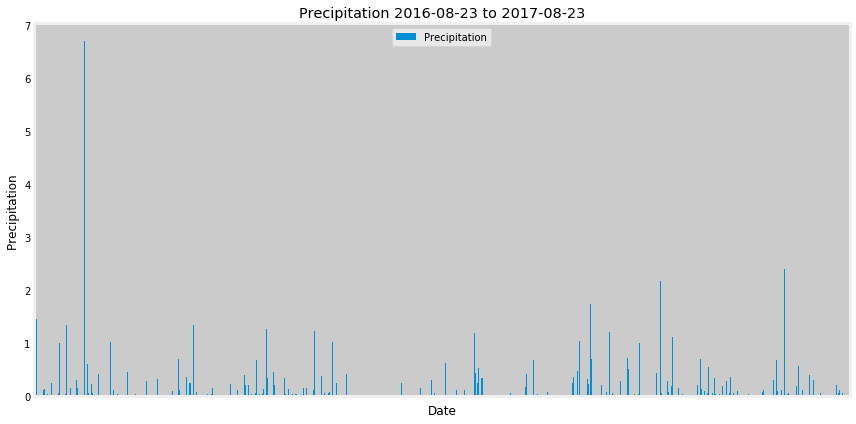

In [17]:
# Sort the dataframe by date

dfTwlv.sort_values(by='Date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

ax=dfTwlv.plot.bar(figsize=(12,6))

ax.set_xticklabels([])
#ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

plt.xlabel('Date')
plt.ylabel('Precipitation ')
plt.title('Precipitation 2016-08-23 to 2017-08-23')
plt.legend(loc='upper center')
plt.tight_layout()

plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [19]:
dfTwlv.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?

numStations= session.query(Station.id).count()
numStations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import distinct
stations=session.query(Measurement.station,func.count(Measurement.station)).\
                                                    group_by(Measurement.station).\
                                                            order_by(func.count(Measurement.station).desc()).all()

stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
mostActiveStation=stations[0][0]
mostActiveStation

'USC00519281'

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tempStats= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                                                                filter(Measurement.station==mostActiveStation).all()

tempStats

[(54.0, 85.0, 71.66378066378067)]

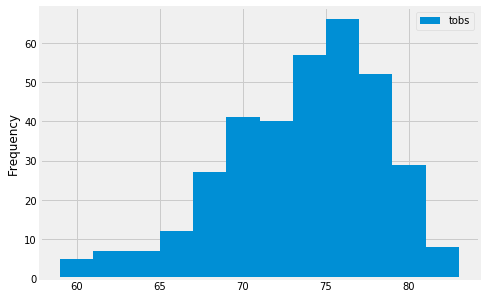

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twlvMonthsTobs=session.query(Measurement.date,Measurement.tobs,Measurement.station).\
                                                filter(Measurement.station==mostActiveStation).\
                                                     filter(Measurement.date > twelve_months).\
                                                                   order_by(Measurement.date).all()
dftobsTwlv=pd.DataFrame(twlvMonthsTobs)
dftobsTwlv.dropna(inplace=True)

dftobsTwlv.plot(kind='hist',figsize=(7,5),bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """ 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tripTemp=calc_temps('2017-02-28', '2017-03-05')
tripTemp

[(64.0, 72.02777777777777, 78.0)]

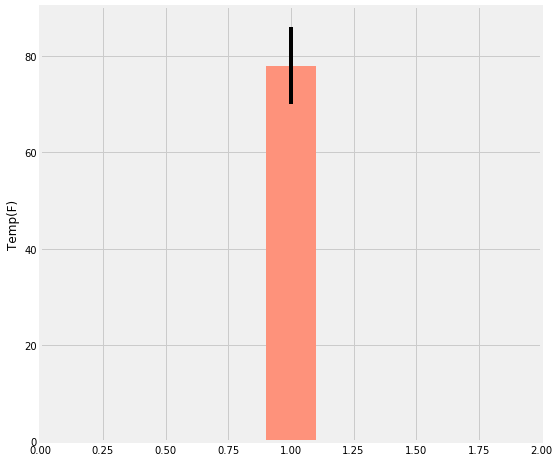

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(8,8))
plt.bar(x=1,height=tripTemp[0][2],yerr=tripTemp[0][1]-tripTemp[0][0],width=.2, align='center',color='#FE927B')
plt.xlim((0, 2))
plt.ylabel('Temp(F)')
plt.show()


In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Measurement.station,
     Measurement.date,
     func.sum(Measurement.prcp),
     Station.station,
     Station.name,
     Station.latitude,
     Station.longitude,
     Station.elevation]

In [29]:
start_date='2017-02-28'
end_date='2017-03-05'

In [30]:
sameStat=session.query(*sel).\
            filter(Measurement.station==Station.station).\
                                group_by(Measurement.station).\
                                    order_by(func.sum(Measurement.prcp).desc()).\
                                        filter(Measurement.date >= start_date).\
                                                        filter(Measurement.date <= end_date).\
                                                                              all()

In [31]:
for record in sameStat:
    print(record)

('USC00519281', '2017-03-05', 4.720000000000001, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', '2017-03-05', 4.45, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00516128', '2017-03-05', 4.07, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00517948', '2017-03-03', 2.98, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
('USC00519397', '2017-03-05', 2.7399999999999998, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519523', '2017-03-04', 2.32, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', '2017-03-03', 1.1600000000000001, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


In [32]:
joinState=session.query(*sel).\
                filter(Measurement.station==Station.station).\
                                filter(Measurement.date >= start_date).\
                                        filter(Measurement.date <= end_date).\
                                                      group_by(Measurement.station).\
                                                               order_by(func.sum(Measurement.prcp).desc()).statement

D:\Anaconda\envs\PythonData\lib\site-packages\sqlalchemy\sql\base.py:528: SAWarning: Column 'station' on table <sqlalchemy.sql.selectable.Select at 0x22b0e0bbf98; Select object> being replaced by Column('station', TEXT(), table=<Select object>), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))


In [33]:
dfJoin=pd.read_sql_query(joinState,session.bind)

In [34]:
df=dfJoin.iloc[:,2:8]

In [35]:
df.head()

,sum_1,station,name,latitude,longitude,elevation
0,4.72,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,4.45,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,4.07,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,2.98,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,2.74,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [36]:
df.rename(columns={'sum_1':'rainfallamount'})

,rainfallamount,station,name,latitude,longitude,elevation
0,4.72,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,4.45,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,4.07,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,2.98,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,2.74,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,2.32,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,1.16,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
d=daily_normals("01-31")

In [38]:
d

[(60.0, 68.47368421052632, 74.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startDate="01-01"
endDate="08-01"


start=datetime.strptime(startDate, '%m-%d')
end=datetime.strptime(endDate, '%m-%d')

# Use the start and end date to create a range of dates

datesRange=pd.date_range(start, end,freq='M',closed=None).tolist()




In [40]:
datesRange

[Timestamp('1900-01-31 00:00:00', freq='M'),
 Timestamp('1900-02-28 00:00:00', freq='M'),
 Timestamp('1900-03-31 00:00:00', freq='M'),
 Timestamp('1900-04-30 00:00:00', freq='M'),
 Timestamp('1900-05-31 00:00:00', freq='M'),
 Timestamp('1900-06-30 00:00:00', freq='M'),
 Timestamp('1900-07-31 00:00:00', freq='M')]

In [41]:
# Stip off the year and save a list of %m-%d strings

dates=[]

for date in datesRange:
    
    month=date.strftime('%m')
    day=date.strftime('%d')
    
    fecha=f"{month}-{day}"
    
    dates.append(fecha)

    # Loop through the list of %m-%d strings and calculate the normals for each date

dates

['01-31', '02-28', '03-31', '04-30', '05-31', '06-30', '07-31']

In [42]:
daily_normals('01-01')

[(62.0, 69.15384615384616, 77.0)]

In [43]:

normMin=[]
normAvg=[]
normMax=[]

for date in dates:
    
    dailyNorm=daily_normals(date)
    normMin.append(dailyNorm[0][0])
    normAvg.append(dailyNorm[0][1])
    normMax.append(dailyNorm[0][2])
    
    

In [44]:
normals=pd.DataFrame({'Tdate':dates,
                     'Tmin':normMin,
                     'Tavg':normAvg,
                     'Tmax':normMax})

In [45]:
normals.set_index('Tdate',inplace=True)

In [46]:
normals

,Tmin,Tavg,Tmax
Tdate,,,
01-31,60.0,68.473684,74.0
02-28,65.0,70.655172,80.0
03-31,61.0,71.875000,79.0
04-30,58.0,71.557692,78.0
05-31,68.0,74.400000,81.0
06-30,67.0,75.596154,81.0
07-31,72.0,77.035714,83.0


In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


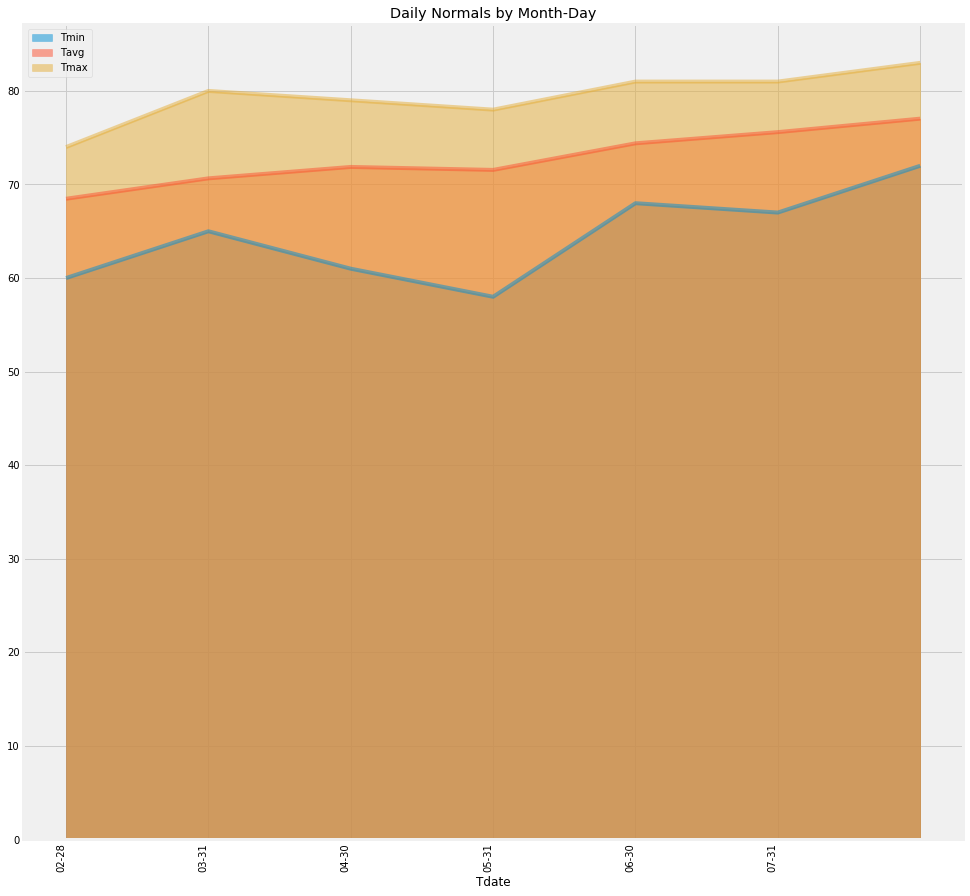

In [48]:
# Plot the daily normals as an area plot with `stacked=False`

ax=normals.plot.area(stacked=False,figsize=(15,15))
#plt.xlim(normals.index[0],normals.index[len(normals.index)-1])
ax.set_xticklabels(normals.index, rotation=90,fontdict={'horizontalalignment':'right'})
#ax.tick_params(axis='x',labelright=True,width=1)
plt.title("Daily Normals by Month-Day")
plt.show()

